# PACE MOANA Data Visualization: Site Map in Atlantic
**Author:** Shailja Gangrade (Brown University). Adapted from Carina Poulin (NASA, SSAI). Prepared for the PACE Hackweek 2025.

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

<div class="alert alert-warning" role="alert">

You need up to 4GB of memory to run this notebook

</div>

[edl]: https://urs.earthdata.nasa.gov/

## Summary

This is an introduction to the visualization possibilities arising from PACE data, meant to give you ideas and tools to develop your own scientific data visualizations.


## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

Set (and persist to your user profile on the host, if needed) your Earthdata Login credentials.

In [4]:
auth = earthaccess.login()

[back to top](#Contents)

## 2. Search for Data

In [5]:
tspan = ("2024-09-01", "2024-09-30")

In [6]:
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    granule_name="*.DAY.*0p1deg*",  # Daily only for MOANA | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

Here we will open the datasets.

In [7]:
path_moana = earthaccess.open(results_moana)

QUEUEING TASKS | :   0%|          | 0/28 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/28 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/28 [00:00<?, ?it/s]

Since we are combining multiple files, we are using the `open_mfdataset` function and indicating that we want to concatenate the data by date.

In [8]:
dataset_moana = xr.open_mfdataset(path_moana, combine="nested", concat_dim="date")
dataset_moana

<xarray.Dataset> Size: 517MB
Dimensions:          (date: 28, lat: 1400, lon: 1100, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    prococcus_moana  (date, lat, lon) float32 172MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 172MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 172MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (date, rgb, eightbitcolor) uint8 22kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240901.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         161683
    data_minimum:                      -inf
    data_maximum:                      inf

[back to top](#Contents)

## 3. Make a quick map with Xarray

Lets make a very quick map using `xr.plot`. All we need is to indicate the variable we want to plot and because our dataset contains multiple date, we indicate the index of one date in brackets with `[0]`.

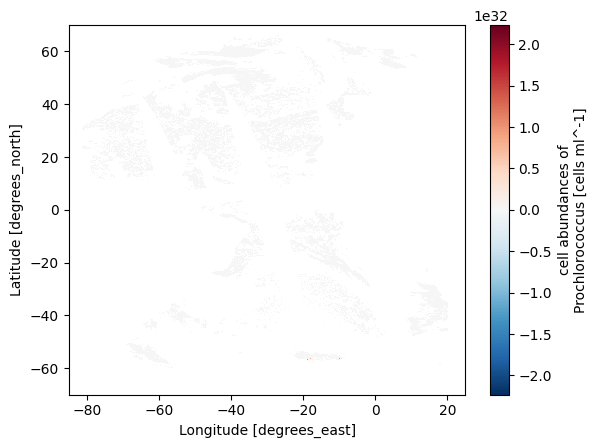

In [9]:
plot = dataset_moana["prococcus_moana"][0].plot.imshow()

Notice that we do not see much. In this case, the dataset contains outliers. If we just want to make a quick plot, we can remove outliers with `robust=true`.

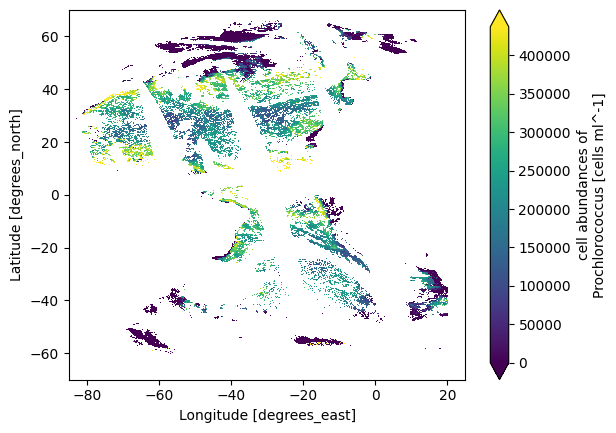

In [10]:
plot = dataset_moana["prococcus_moana"][0].plot.imshow(robust="true")

[back to top](#Contents)

## 4. Clean up the dataset

Because we want to do statistics on the data and not only draw a quick plot, we are going to clean up the dataset. Thankfully, the dataset comes with atttributes that indicate `valid_max` and `valid_min` values to guide us.

In [11]:
dataset_moana

<xarray.Dataset> Size: 517MB
Dimensions:          (date: 28, lat: 1400, lon: 1100, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    prococcus_moana  (date, lat, lon) float32 172MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 172MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 172MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (date, rgb, eightbitcolor) uint8 22kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240901.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         161683
    data_minimum:                      -inf
    data_maximum:                      inf

In [12]:
dataset_moana["prococcus_moana"] = dataset_moana["prococcus_moana"].clip(
    min=dataset_moana["prococcus_moana"].attrs["valid_min"],
    max=dataset_moana["prococcus_moana"].attrs["valid_max"],
)
dataset_moana["syncoccus_moana"] = dataset_moana["syncoccus_moana"].clip(
    min=dataset_moana["syncoccus_moana"].attrs["valid_min"],
    max=dataset_moana["syncoccus_moana"].attrs["valid_max"],
)
dataset_moana["picoeuk_moana"] = dataset_moana["picoeuk_moana"].clip(
    min=dataset_moana["picoeuk_moana"].attrs["valid_min"],
    max=dataset_moana["picoeuk_moana"].attrs["valid_max"],
)

We will also remove the variables we will not be using for this example with `drop_vars`.

In [13]:
dataset_phy = dataset_moana.drop_vars(["palette"])

### Average

If you want, calculate the average of the datasets (useful here only if you have equivalent monthly data for both, i.e. if you have one month of data).

In [14]:
dataset_phy = dataset_phy.mean("date")

[back to top](#Contents)

## 5. Plot data from a transect

We can have a quick look at the values for a "transect" at a selected longitude using `sel` and `method='nearest'`

In [15]:
lon_val = -30
transect = dataset_phy.sel(lon=lon_val, method="nearest")

# Select a longitudinal average
# lon_min = -30, lon_max = 20
# transect = dataset_phy.sel(lon=lon_val, method="nearest")

# sst.sel(latitude=coords[0], longitude=coords[1], method='nearest').mean().values)

Making a quick plot with latitudes on the y axis.

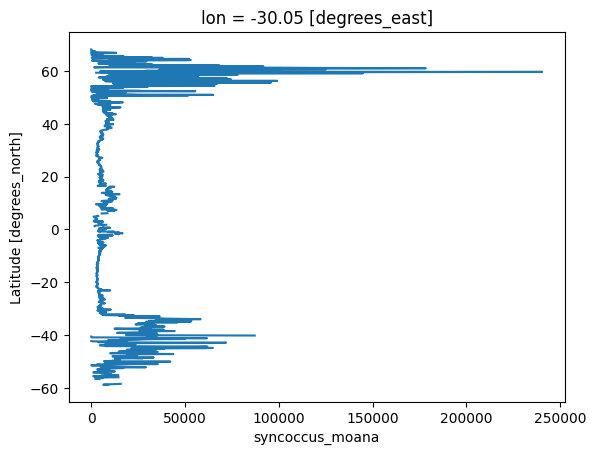

In [16]:
plot = transect["syncoccus_moana"].plot(y="lat")

We can see there are some values missing, we can interpolate the data if we want to, but it is entirely optional.

[back to top](#Contents)

## 6. Interpolate the data

### MOANA (Optional)

Here we offer the option of interpolating the data. This can be useful for filling gaps in the dataset, which can make visualizations smoother. Consider how it affects your statistics before using.

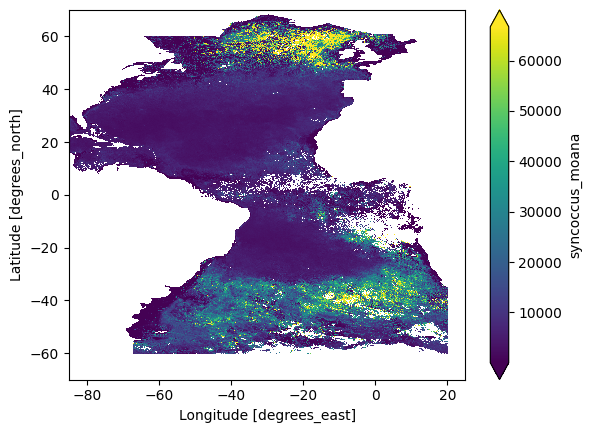

In [17]:
plot = dataset_phy["syncoccus_moana"].plot.imshow(robust="true")

The `margin` parameter is the number of pixels on the X and Y axes to be considered in the calculation.

In [18]:
margin = 1

We need to first create a grid.

In [19]:
grid_pro = pyinterp.backends.xarray.Grid2D(dataset_phy["prococcus_moana"])
grid_syn = pyinterp.backends.xarray.Grid2D(dataset_phy["syncoccus_moana"])
grid_pic = pyinterp.backends.xarray.Grid2D(dataset_phy["picoeuk_moana"])

Then interpolate the gridded data and transpose it back into its shape.

In [20]:
pro = pyinterp.fill.loess(grid_pro, nx=margin, ny=margin)
syn = pyinterp.fill.loess(grid_syn, nx=margin, ny=margin)
pic = pyinterp.fill.loess(grid_pic, nx=margin, ny=margin)

dataset_phy["prococcus_moana"][...] = pro.transpose()
dataset_phy["syncoccus_moana"][...] = syn.transpose()
dataset_phy["picoeuk_moana"][...] = pic.transpose()

If we have a look at the transect again, we can see that some of the values have been filled in by the interpolation.

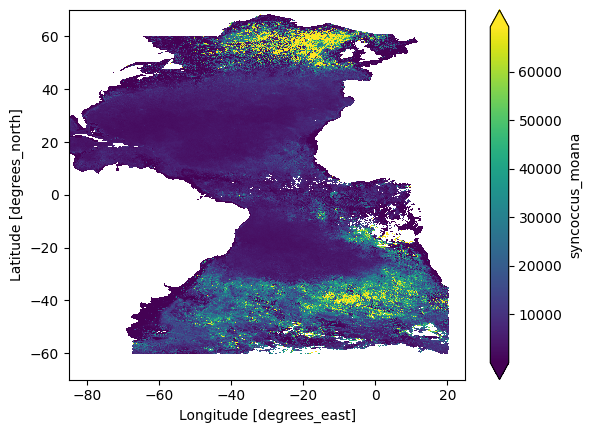

In [21]:
plot = dataset_phy["syncoccus_moana"].plot.imshow(robust="true")

### Normalize data

We normalize in order to visualize and compare multiple variables together.

In [25]:
dataset_norm = dataset_phy.astype(np.float64)
dataset_norm = (
    (dataset_phy - dataset_phy.min())
    / (dataset_phy.max() - dataset_phy.min())
)

In [26]:
data_norm = dataset_norm.to_dataarray()
# data_norm_v = dataset_v_norm.to_dataarray()

[back to top](#Contents)

## 7. Make a multi-variable RBG map with two datasets

We will use the `plot.imshow` function to represent our variables by intensities of Red, Green, and Blue. We can use `sel` to reorder the dataset because the visualization will go in the order of Red, Green, and Blue.

In [27]:
data_norm = data_norm.sel(
    variable=["syncoccus_moana", "picoeuk_moana", "prococcus_moana"]
)
# data_norm_v = data_norm_v.sel(variable=["car", "cire", "mari"])

This is an example of how to show multiple variables from two different datasets on the same map. We can choose the color the land and ocean backgrounds using `cfeature.NaturalEarthFeature`. We also order the overlapping layers using `zorder`, the higher the number, the higher the layer is. `fig.patch.set_alpha(0.0)` is used to remove the background of the image when saving as a png.

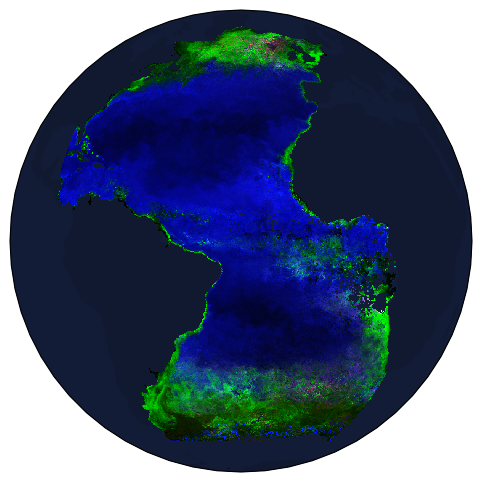

In [29]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(projection=ccrs.Orthographic(-30, 0), facecolor="#080c17")
ax1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical",
        "ocean",
        "110m",
        edgecolor="face",
        facecolor="#131c36",
    ),
    alpha=1,
    zorder=1,
)
ax1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical",
        "land",
        "110m",
        edgecolor="face",
        facecolor="#131c36",
    ),
    alpha=0.85,
    zorder=2,
)

ax2 = data_norm.plot.imshow(
    transform=ccrs.PlateCarree(), interpolation="none", zorder=3
)
# ax3 = data_norm_v.plot.imshow(
#     transform=ccrs.PlateCarree(), interpolation="none", zorder=4
# )

fig.patch.set_alpha(0.0)
plt.show()

We export the figure of a chosen name, format and resolution (dpi). `str(tspan)` adds the date range to the name, you can use other variables in strings in the same way.

In [33]:
# fig.savefig("moana_and_land_vi" + str(tspan) + ".png", format="png", dpi=600)
fig.savefig("moana_snapshot_Sep2024" + str(tspan) + ".png", format="png", dpi=600)

We can create a RGB ternary legend for our map. This was shamelessly inspired by the [EDMW EarthData Workshop 2025] , check their GitHub repo for even more inspiration for PACE visualizations!

[EDMW EarthData Workshop 2025]: https://github.com/nmfs-opensci/EDMW-EarthData-Workshop-2025/blob/main/tutorials/Tutorial_3_moana-erddap.ipynb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0361083769357971e-05..1.3235352017821065].


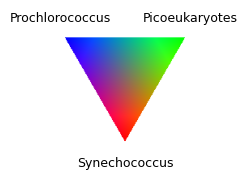

In [36]:
size = 200
x = np.linspace(-1, 1, size)
y = np.linspace(-1, 1, size)
X, Y = np.meshgrid(x, y)

# Equilateral triangle with center at origin
# Barycentric coordinates
R = (-Y + 0.65) / 0.97
G = (X * 0.866 + Y * 0.5 + 0.32) / 0.97
B = (-X * 0.866 + Y * 0.5 + 0.32) / 0.97

# Only show points inside triangle
mask = (R >= 0) & (G >= 0) & (B >= 0)
rgb = np.ones((size, size, 3))
rgb[mask] = np.stack([R[mask], G[mask], B[mask]], axis=1)

fig_tri = plt.figure(figsize=(2.5, 2.5))
plt.imshow(rgb, extent=[-1, 1, -1, 1], origin="lower")

plt.text(0, -0.9, "Synechococcus", ha="center", va="center", fontsize=9)
# plt.text(0, -0.75, "car", ha="center", va="center", fontsize=9)
plt.text(-0.8, 0.9, "Prochlorococcus", ha="center", va="center", fontsize=9)
# plt.text(-0.8, 0.75, "mari", ha="center", va="center", fontsize=9)
plt.text(0.8, 0.9, "Picoeukaryotes", ha="center", va="center", fontsize=9)
# plt.text(0.8, 0.75, "cire", ha="center", va="center", fontsize=9)


plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
fig_tri.savefig("color_triangle_ProSynPico" + str(tspan) + ".png", format="png", dpi=600)

## Add AMT transect data

In [40]:
AMT_df = pd.read_csv('AMT28_underway_latlon.csv')

In [43]:
lats = AMT_df.Lat, lons = AMT_df.Lon

(0      -5.502
 1      -5.676
 2      -5.908
 3      -6.108
 4      -6.332
         ...  
 772   -52.436
 773   -52.572
 774   -52.572
 775   -52.572
 776   -52.692
 Name: Lon, Length: 777, dtype: float64,
 0      49.638
 1      49.581
 2      49.501
 3      49.429
 4      49.355
         ...  
 772   -48.014
 773   -48.115
 774   -48.115
 775   -48.115
 776   -48.199
 Name: Lat, Length: 777, dtype: float64)

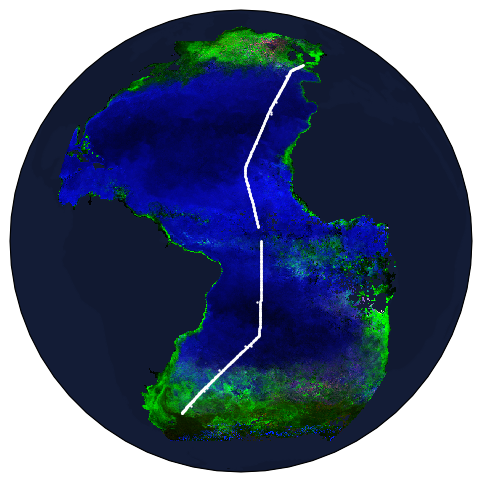

In [62]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(projection=ccrs.Orthographic(-30, 0), facecolor="#080c17")
ax1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical",
        "ocean",
        "110m",
        edgecolor="face",
        facecolor="#131c36",
    ),
    alpha=1,
    zorder=1,
)
ax1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical",
        "land",
        "110m",
        edgecolor="face",
        facecolor="#131c36",
    ),
    alpha=0.85,
    zorder=2,
)

ax2 = data_norm.plot.imshow(
    transform=ccrs.PlateCarree(), interpolation="none", zorder=3
)

ax1.scatter(lons, lats, color='white', marker='o', s=0.5, transform=ccrs.PlateCarree(), label='AMT', zorder=4)

# ax3 = data_norm_v.plot.imshow(
#     transform=ccrs.PlateCarree(), interpolation="none", zorder=4
# )

fig.patch.set_alpha(0.0)
plt.show()

fig.savefig("moana_snapshot_Sep2024_withAMTstns" + str(tspan) + ".png", format="png", dpi=600)
